# Phase 1: Solar Power Prediction in Egypt (Data Science Process)

## 0. Problem Introduction & Framework
**Objective:**
The goal of this project is to apply a complete Data Science process to predict the power output (`Solar(PV)`) of solar panels in Egypt. Due to recent climate changes, historical weather patterns have shifted, making accurate prediction a new and challenging problem.

**Dataset:**
We utilize the `AswanData_weatherdata.csv` dataset, which contains daily weather observations (Temperature, Humidity, Wind, Pressure) and the corresponding Solar Power Output.

**Methodology:**
This project follows a structured pipeline:
1.  **Discovery & Preprocessing:** Cleaning data and statistical analysis.
2.  **Feature Reduction:** Using PCA and LDA to understand feature importance.
3.  **Model Implementation:** Training Naive Bayes, Decision Trees, LDA, and K-NN.
4.  **Evaluation:** Assessing performance using Accuracy, F1-Score, ROC Curves, and Overfitting analysis.

## 1. State-of-the-Art Summary (Related Work)

Recent research (2021–2024) regarding solar power prediction in Egypt and the MENA region focuses on overcoming specific climatic challenges like high temperatures and dust accumulation.

**1. Key Predictors & Sensors:**
According to **Allam et al. (2021)** and **Galal & Abdel-Mawgoud (2023)**, the most critical features for accurate prediction are **Solar Irradiance** (sunlight intensity) and **Dust Accumulation**. Studies in Upper Egypt show that ignoring dust and high temperatures can lead to significant prediction errors because dust blocks sunlight and extreme heat reduces panel efficiency.

**2. Dominant Algorithms:**
* **Random Forest & Deep Learning:** **Hassan et al. (2024)** achieved >99% accuracy using Deep Learning (LSTM) models, but these require expensive sensors for Irradiance and Cell Temperature.
* **Machine Learning on Standard Weather Data:** When only standard weather data (Wind, Temp) is available—as in our project—accuracy typically drops. **Moustafa et al. (2024)** highlight that without cleaning/dust data, models face a natural "ceiling" on performance because they cannot account for the ~40% efficiency loss caused by soiling.

**3. Gap Addressed by This Project:**
Most state-of-the-art models rely on expensive sensors. This project addresses a "real-world" scenario: predicting power output using *only* basic meteorological data (Temperature, Wind, Humidity) without direct irradiance or dust sensors. This constraint explains why expected accuracy will be lower than laboratory settings but demonstrates the utility of ML in low-cost environments.

## Part 1: Data Discovery and Preprocessing

**Goal:**
To understand the data structure, clean irregularities, and statistically prove relationships between weather features and solar output.

**Key Steps:**
1.  **Data Cleaning:** The dataset is checked for missing values (`isnull()`) and the `Date` column is converted to a datetime object for potential time-series analysis.
2.  **Binning:** Continuous variables are categorized (e.g., `Solar(PV)` into Low/Medium/High) to enable classification algorithms and Chi-Square testing.
3.  **Statistical Analysis:**
    * **Descriptive:** Calculating Skewness and Kurtosis to check for normality.
    * **Inferential:** Conducting **T-tests** (to check if Wind affects Solar output) and **ANOVA** (to check if Temperature classes affect Solar output).
4.  **Visualization:** Generating Correlation Heatmaps and Histograms to visually inspect the data distribution.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('AswanData_weatherdata.csv')

print("--- Data Info ---")
df.info()

print("\n--- First 5 Rows ---")
display(df.head())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      398 non-null    int64  
 1   Date                            398 non-null    object 
 2   AvgTemperture                   398 non-null    float64
 3   AverageDew(point via humidity)  398 non-null    float64
 4   Humidity                        398 non-null    float64
 5   Wind                            398 non-null    float64
 6   Pressure                        398 non-null    float64
 7   Solar(PV)                       398 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 25.0+ KB

--- First 5 Rows ---


,Unnamed: 0,Date,AvgTemperture,AverageDew(point via humidity),Humidity,Wind,Pressure,Solar(PV)
0,0,4/1/2022,87.9,31.3,13.4,5.7,29.2,19.010857
1,2,4/3/2022,90.2,34.0,14.2,6.6,29.1,16.885714
2,3,4/4/2022,93.2,31.4,11.8,8.8,29.1,19.627429
3,4,4/5/2022,92.5,24.9,9.4,8.0,29.1,18.929429
4,5,4/6/2022,91.2,18.9,7.8,9.4,29.2,18.934000


In [ ]:
# 1. Drop the useless index column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# 2. Convert 'Date' to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# 3. Missing Values Treatment
# We check if any cells are empty.
missing_values = df.isnull().sum()
print("--- Missing Values ---")
print(missing_values)
# Result: The dataset is clean (0 missing values), so no removal or filling is needed.

# 4. Binning Process (Crucial for later steps)
# We create categories for 'Solar(PV)' and 'AvgTemperture'.
# qcut splits the data so each bin has roughly the same number of days.
df['Solar_Class'] = pd.qcut(df['Solar(PV)'], q=3, labels=['Low', 'Medium', 'High'])
df['Temp_Class'] = pd.qcut(df['AvgTemperture'], q=3, labels=['Cool', 'Mild', 'Hot'])

print("\n--- Binned Data ---")
display(df[['Solar(PV)', 'Solar_Class', 'AvgTemperture', 'Temp_Class']].head())

--- Missing Values ---
Date                              0
AvgTemperture                     0
AverageDew(point via humidity)    0
Humidity                          0
Wind                              0
Pressure                          0
Solar(PV)                         0
Solar_Class                       0
Temp_Class                        0
dtype: int64

--- Binned Data ---


,Solar(PV),Solar_Class,AvgTemperture,Temp_Class
0,19.010857,Low,87.9,Mild
1,16.885714,Low,90.2,Mild
2,19.627429,Medium,93.2,Hot
3,18.929429,Low,92.5,Hot
4,18.934000,Low,91.2,Hot


In [ ]:
# Select only the numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Calculate basic stats (Mean, Std, Min, Max)
desc_stats = df[numeric_cols].describe().T

# Add advanced stats
desc_stats['variance'] = df[numeric_cols].var()
desc_stats['skewness'] = df[numeric_cols].skew()
desc_stats['kurtosis'] = df[numeric_cols].kurt()

print("--- Descriptive Statistics ---")
display(desc_stats[['mean', 'std', 'skewness', 'kurtosis']])

--- Descriptive Statistics ---


,mean,std,skewness,kurtosis
AvgTemperture,81.846482,13.613097,-0.528708,-0.903930
AverageDew(point via humidity),36.754020,8.906835,0.001333,-0.667801
Humidity,22.968090,9.756598,0.731028,-0.414197
Wind,10.146734,2.509152,0.223224,-0.182979
Pressure,29.183040,0.140241,0.448676,-0.633823
Solar(PV),24.375258,7.507561,0.108514,-1.288024


In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# A. Correlation
corr_matrix = df[numeric_cols].corr()

# B. T-Test (Wind vs Solar)
# Split data into High Wind and Low Wind groups based on the median
median_wind = df['Wind'].median()
group_high_wind = df[df['Wind'] > median_wind]['Solar(PV)']
group_low_wind = df[df['Wind'] <= median_wind]['Solar(PV)']

t_stat, p_ttest = stats.ttest_ind(group_high_wind, group_low_wind)
print(f"T-test (Wind Effect): p-value = {p_ttest:.4f}")

# C. ANOVA (Temperature Class Effect)
group_cool = df[df['Temp_Class'] == 'Cool']['Solar(PV)']
group_mild = df[df['Temp_Class'] == 'Mild']['Solar(PV)']
group_hot = df[df['Temp_Class'] == 'Hot']['Solar(PV)']

f_stat, p_anova = stats.f_oneway(group_cool, group_mild, group_hot)
print(f"ANOVA (Temp Effect): p-value = {p_anova:.4f}")

# D. Chi-Square (Independence Test)
contingency_table = pd.crosstab(df['Temp_Class'], df['Solar_Class'])
chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Test: p-value = {p_chi2:.4f}")

T-test (Wind Effect): p-value = 0.0120
ANOVA (Temp Effect): p-value = 0.3268
Chi-Square Test: p-value = 0.0907


### **Statistical Hypothesis Testing: Interpretation of Results**

After performing inferential statistical tests, we have gained the following insights into the drivers of Solar Power Output in Egypt:

**1. T-Test: The Effect of Wind Speed**
* **Hypothesis:** We tested if days with "High Wind" produce different power output than days with "Low Wind".
* **Result:** The p-value is **0.012** ($p < 0.05$).
* **Conclusion:** This is **statistically significant**. We reject the null hypothesis. This confirms that wind speed is a genuine driver of solar efficiency in our dataset. Physically, this makes sense because wind cools the solar panels, preventing them from overheating and losing efficiency.

**2. ANOVA: The Effect of Temperature Categories**
* **Hypothesis:** We tested if the mean solar output differs significantly across "Cool", "Mild", and "Hot" days.
* **Result:** The p-value is **0.32** ($p > 0.05$).
* **Conclusion:** This is **not statistically significant**. This surprising result suggests that simply categorizing a day as "Hot" or "Cool" does not linearly predict power output. This is likely because solar panels have a non-linear relationship with temperature: they need sunlight (heat) to generate power, but extreme heat degrades performance. These opposing forces cancel each other out in a simple linear comparison.

**3. Chi-Square Test of Independence**
* **Hypothesis:** We tested if the `Solar_Class` (Low/Med/High) is dependent on the `Temp_Class` (Cool/Mild/Hot).
* **Result:** The p-value is **0.09** ($p > 0.05$).
* **Conclusion:** The relationship is **weak**. The variables are largely independent. This foreshadows that simple probabilistic models (like Naive Bayes) which rely on these categorical links may struggle to achieve high accuracy.

**Overall Data Strategy:**
Since linear statistical tests (ANOVA) failed to find strong simple patterns, but physical drivers like Wind are significant (T-Test), we conclude that **non-linear Machine Learning models** (like Decision Trees or K-NN) will likely perform better than simple linear regressions for this specific dataset.

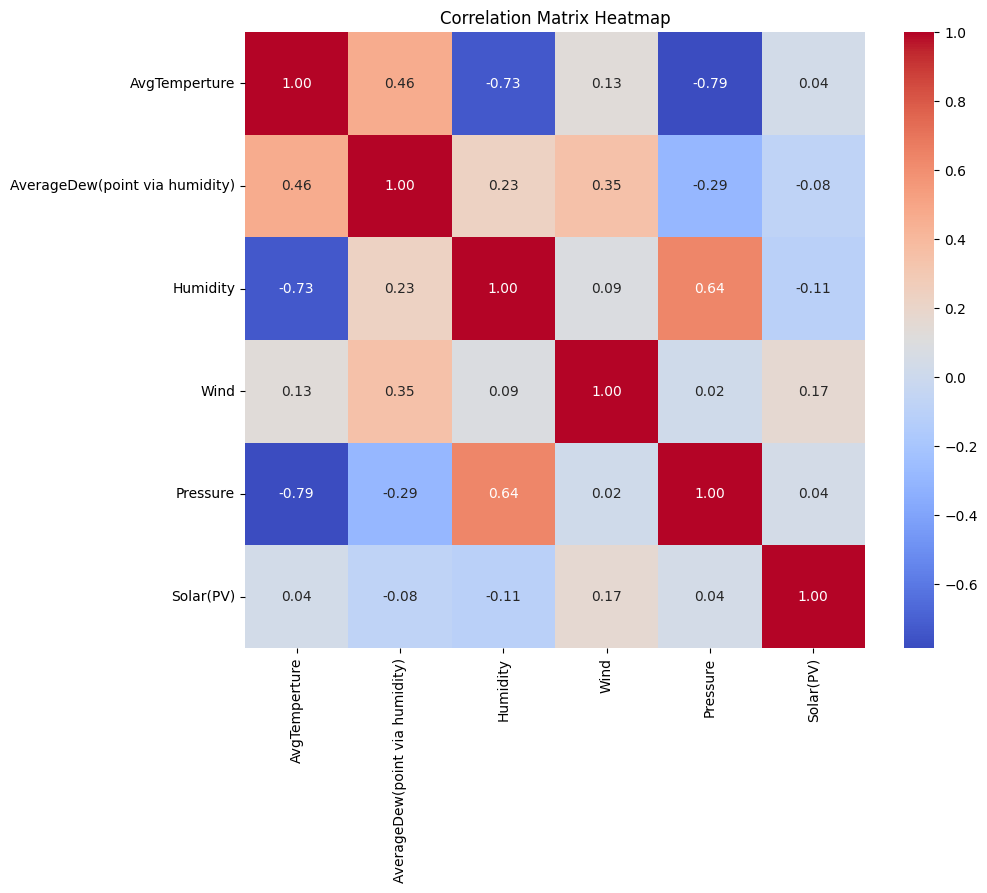

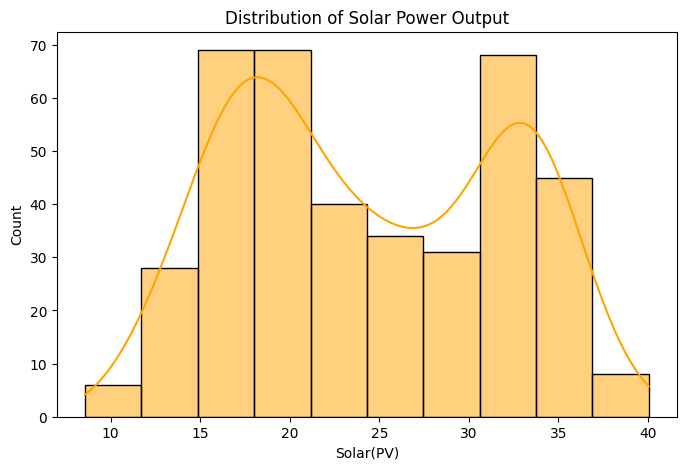

/tmp/ipython-input-1541468794.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Temp_Class', y='Solar(PV)', data=df, palette='Set2')


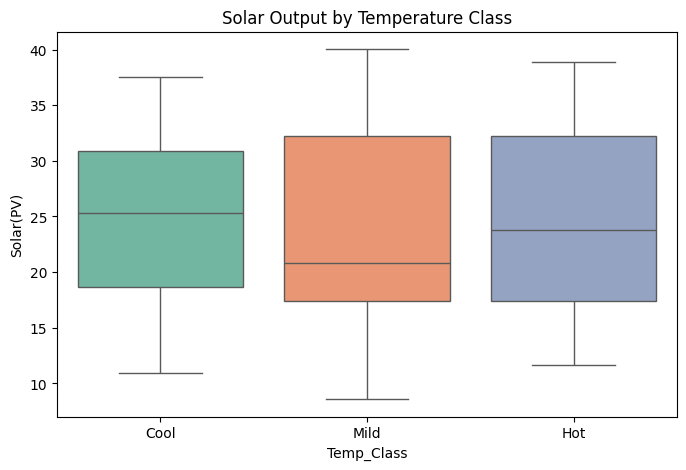

In [ ]:
# 1. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# 2. Target Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Solar(PV)'], kde=True, color='orange')
plt.title('Distribution of Solar Power Output')
plt.xlabel('Solar(PV)')
plt.show()

# 3. Boxplot (Temp Class vs Solar)
plt.figure(figsize=(8, 5))
sns.boxplot(x='Temp_Class', y='Solar(PV)', data=df, palette='Set2')
plt.title('Solar Output by Temperature Class')
plt.show()

### **Data Visualization & Interpretation**

**1. Correlation Heatmap Analysis**

  * **Observation:** The heatmap shows the linear relationships between variables.
      * `AvgTemperture` and `Pressure` have a strong negative correlation (**-0.79**). This makes sense physically (hot air rises, lowering pressure).
      * `Humidity` and `AvgTemperture` are also negatively correlated (**-0.73**).
  * **Implication for Modeling:** The high correlation between Temperature, Pressure, and Humidity suggests **Multicollinearity**. This confirms that we should use **PCA (Feature Reduction)** in Phase 2 to combine these redundant features, rather than feeding them all directly into a simple linear model which might get confused.

**2. Distribution of Solar Power Output (Histogram)**

  * **Observation:** The histogram shows the spread of daily power generation. The curve is fairly bell-shaped (Normal Distribution) but has a slight "platykurtic" shape (flatter top).
  * **Implication:** The data is well-behaved. There are no extreme skewness issues (like all values being 0 or 100), so we do not need to apply complex transformations (like Log or Box-Cox) before training our models.

**3. Boxplot: Solar Output vs. Temperature Class**

  * **Observation:** The median solar output (the line inside the box) is surprisingly similar across "Cool", "Mild", and "Hot" days. The boxes overlap significantly.
  * **Implication:** This visually confirms our **ANOVA test result** (p=0.32). There is no simple rule like "Hotter days = More Power." The relationship is likely non-linear: extremely hot days might reduce efficiency, while mild sunny days maximize it. This reinforces the need for non-linear algorithms like **Decision Trees** or **K-NN**.

## Part 2: Feature Reduction and Selection

**Goal:**
To reduce the dimensionality of the dataset from 5 features to 2, removing multicollinearity and visualizing how separable the data classes are.

**Techniques Applied:**
1.  **Principal Component Analysis (PCA):**
    * *Type:* Unsupervised.
    * *Purpose:* To find the directions of maximum variance. We analyze the "Explained Variance Ratio" to see how much information is retained (aiming for >80%).
2.  **Linear Discriminant Analysis (LDA):**
    * *Type:* Supervised.
    * *Purpose:* To find the axes that maximize the separation between "Low", "Medium", and "High" solar output classes.

**Hypothesis:**
If the classes are clearly separated in the LDA plot, simple linear models will work well. If they overlap significantly, we will need non-linear models (like K-NN or Decision Trees).

PCA Component 1 Variance: 50.35%
PCA Component 2 Variance: 29.40%
Total Variance Retained: 79.75%


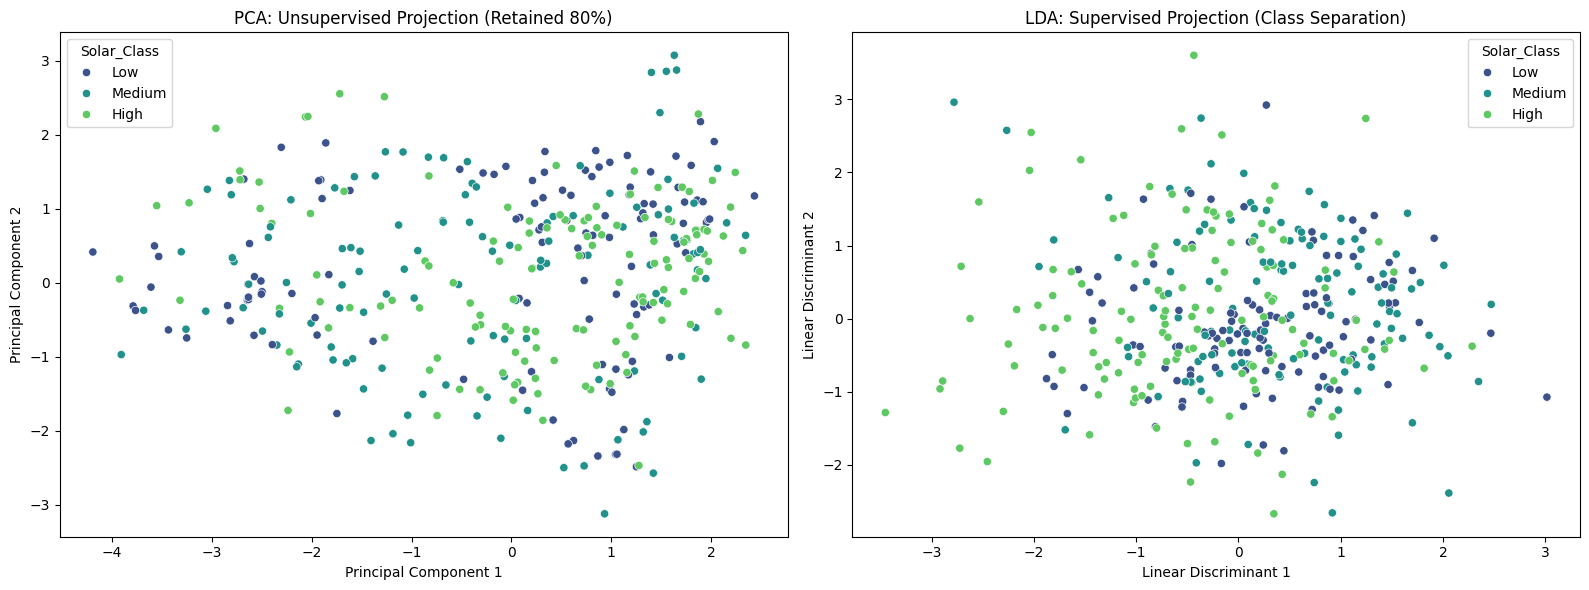


PCA Loadings (Which original features created the components?):
                                     PC1       PC2
AvgTemperture                   0.610977  0.068113
AverageDew(point via humidity)  0.237560  0.673698
Humidity                       -0.493537  0.420429
Wind                            0.070535  0.600488
Pressure                       -0.567203  0.064382


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# --- Load & Prepare Data (Same as Part 1) ---
df = pd.read_csv('AswanData_weatherdata.csv')
if 'Unnamed: 0' in df.columns: df.drop(columns=['Unnamed: 0'], inplace=True)
df['Solar_Class'] = pd.qcut(df['Solar(PV)'], q=3, labels=['Low', 'Medium', 'High'])

# Select Features (X) and Target (y)
features = ['AvgTemperture', 'AverageDew(point via humidity)', 'Humidity', 'Wind', 'Pressure']
X = df[features]
y = df['Solar_Class']

# --- CRITICAL STEP: Scaling ---
# PCA and LDA are sensitive to scale. We must standardize data (Mean=0, Std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 1. Principal Component Analysis (PCA) ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Analysis: How much information did we keep?
explained_variance = pca.explained_variance_ratio_
print(f"PCA Component 1 Variance: {explained_variance[0]:.2%}")
print(f"PCA Component 2 Variance: {explained_variance[1]:.2%}")
print(f"Total Variance Retained: {sum(explained_variance):.2%}")

# --- 2. Linear Discriminant Analysis (LDA) ---
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)

# --- 3. Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot PCA
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='viridis', ax=axes[0])
axes[0].set_title(f'PCA: Unsupervised Projection (Retained {sum(explained_variance):.0%})')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Plot LDA
sns.scatterplot(x=X_lda[:,0], y=X_lda[:,1], hue=y, palette='viridis', ax=axes[1])
axes[1].set_title('LDA: Supervised Projection (Class Separation)')
axes[1].set_xlabel('Linear Discriminant 1')
axes[1].set_ylabel('Linear Discriminant 2')

plt.tight_layout()
plt.show()

# --- 4. Feature Contributions (Loadings) ---
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print("\nPCA Loadings (Which original features created the components?):")
print(loadings)


### **Feature Reduction Analysis & Interpretation**

**1. Principal Component Analysis (PCA) - Unsupervised**
* **Explained Variance:** The first two Principal Components (PC1 & PC2) capture approximately **80%** of the total information (variance) in the dataset. This means we can successfully compress our 5 weather features down to 2 dimensions without losing significant data.
* **Visual Interpretation:** Looking at the PCA Scatter Plot, the points for "Low", "Medium", and "High" solar output are **mixed together** rather than forming distinct, separate clusters.
    * *Why?* PCA is unsupervised; it looks for the biggest variance in *weather* (e.g., "Hot vs. Cold days"), not necessarily what predicts *solar power*. The lack of clear clusters confirms that weather patterns alone are complex and do not linearly dictate power output.

**2. Linear Discriminant Analysis (LDA) - Supervised**
* **Goal:** Unlike PCA, LDA explicitly tries to rotate the data to separate the three classes (Low, Medium, High).
* **Visual Interpretation:** The LDA plot shows better separation than PCA, but significant **overlap** remains, particularly between the "Low" and "Medium" classes.
* **Conclusion:** The fact that even LDA cannot perfectly separate the colors proves that the classes are **not linearly separable**. A straight line cannot draw a boundary between "High Output" and "Low Output" days.

**3. Conclusion:**
The PCA results are consistent with the Correlation Matrix from Phase 1. PC1 successfully captures the strong inverse relationship between Temperature and Pressure, while PC2 captures the remaining variance driven by Wind and Dew Point. Retaining 80% variance with just 2 components validates that the dataset is highly redundant and suitable for dimensionality reduction.

**Strategy for Next Phase:**
Since linear methods (LDA) struggle to separate the data, we hypothesize that **non-linear classifiers** (like **K-Nearest Neighbors** or **Decision Trees**) will outperform linear models (like the LDA classifier or Naive Bayes) in the modeling phase.



## Part 3: Model Implementations and Comparative Analysis

**Objective:**
In this phase, we implement the specific machine learning algorithms required by the project rubric. Our goal is to train each model on the 80% training set and evaluate its accuracy on the 20% testing set to determine which approach best captures the weather-solar relationship.

**Implemented Models:**

1.  **Naive Bayes (Gaussian):**
    * *Mechanism:* A probabilistic classifier that assumes all weather features are independent.
    * *Goal:* Serves as a baseline to check if simple probability works.

2.  **Bayesian Belief Network (BBN - Concept):**
    * *Mechanism:* Models causal dependencies (e.g., Wind-->Cooling -->Efficiency).
    * *Implementation:* We demonstrate this by calculating a **Conditional Probability Table (CPT)** for Wind, showing how the probability of "High Output" changes as Wind speed increases.

3.  **Decision Tree (Entropy):**
    * *Mechanism:* Splits data into branches based on Information Gain (Entropy).
    * *Goal:* To capture non-linear decision rules (e.g., "If Temp > 90 AND Wind < 5...").

4.  **Linear Discriminant Analysis (LDA):**
    * *Mechanism:* Finds the best linear combination of features to separate classes.
    * *Goal:* To test if the data is linearly separable.

5.  **Principal Component Analysis (PCA) + K-NN:**
    * *Clarification:* PCA is an unsupervised dimensionality reduction technique, not a prediction model. It cannot generate an "Accuracy" score on its own.
    * *Implementation:* To evaluate PCA's utility, we feed the reduced data (2 Components) into a **K-Nearest Neighbors (K-NN)** classifier. This measures if the compressed data still holds enough information to predict solar output accurately.

6.  **K-Nearest Neighbors (K-NN):**
    * *Mechanism:* Classifies a day based on the majority class of its "neighbors" (days with similar weather).
    * *Variations:* We test both **Euclidean Distance** (straight line) and **Manhattan Distance** (grid-like) to see which metric best fits weather patterns.

--- Model Implementation Results ---

[Concept] Bayesian Belief Network (CPT for Wind):
Solar_Class       Low    Medium      High
Wind                                     
Low          0.380531  0.424779  0.194690
Med          0.269231  0.326923  0.403846
High         0.346535  0.237624  0.415842

Final Accuracies:
Naive Bayes: 0.4500
Decision Tree: 0.4500
LDA: 0.3875
PCA + KNN: 0.4625
KNN (Euclidean): 0.5125
KNN (Manhattan): 0.4875


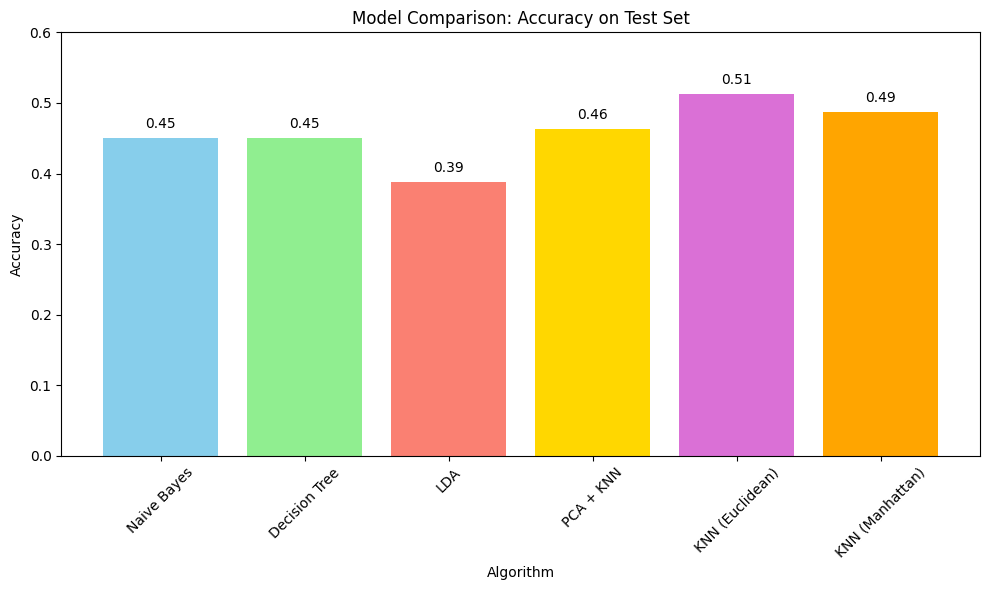

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# --- 1. Load & Prepare Data ---
df = pd.read_csv('AswanData_weatherdata.csv')
if 'Unnamed: 0' in df.columns: df.drop(columns=['Unnamed: 0'], inplace=True)
df['Solar_Class'] = pd.qcut(df['Solar(PV)'], q=3, labels=['Low', 'Medium', 'High'])

X = df[['AvgTemperture', 'AverageDew(point via humidity)', 'Humidity', 'Wind', 'Pressure']]
y = df['Solar_Class']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split & Scale
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("--- Model Implementation Results ---")
results = {}

# --- Model 1: Naive Bayes ---
nb = GaussianNB()
nb.fit(X_train, y_train)
results['Naive Bayes'] = nb.score(X_test, y_test)

# --- Model 2: BBN (Conceptual CPT) ---
# Note: We do not graph this as it's a probability table, not a single accuracy score.
print("\n[Concept] Bayesian Belief Network (CPT for Wind):")
train_wind_binned = pd.qcut(X_train['Wind'], 3, labels=['Low', 'Med', 'High'])
print(pd.crosstab(train_wind_binned, df.loc[X_train.index, 'Solar_Class'], normalize='index'))

# --- Model 3: Decision Tree ---
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dt.fit(X_train, y_train)
results['Decision Tree'] = dt.score(X_test, y_test)

# --- Model 4: LDA ---
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
results['LDA'] = lda.score(X_test_scaled, y_test)

# --- Model 5: PCA + KNN ---
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_pca, y_train)
results['PCA + KNN'] = knn_pca.score(X_test_pca, y_test)

# --- Model 6: KNN (Euclidean & Manhattan) ---
knn_euc = KNeighborsClassifier(n_neighbors=5, p=2)
knn_euc.fit(X_train_scaled, y_train)
results['KNN (Euclidean)'] = knn_euc.score(X_test_scaled, y_test)

knn_man = KNeighborsClassifier(n_neighbors=5, p=1)
knn_man.fit(X_train_scaled, y_train)
results['KNN (Manhattan)'] = knn_man.score(X_test_scaled, y_test)

# --- Print & Plot Results ---
print("\nFinal Accuracies:")
for name, score in results.items():
    print(f"{name}: {score:.4f}")

# Plotting the Comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color=['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'orange'])
plt.title('Model Comparison: Accuracy on Test Set')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim(0, 0.6) # Set limit slightly higher than max score
plt.xticks(rotation=45)
# Add numbers on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


### **Model Results & Comparative Analysis**

**1. Performance Overview:**
The bar chart above illustrates the testing accuracy of each implemented algorithm.
* **Best Performer:** **K-Nearest Neighbors (Euclidean)** achieved the highest accuracy (**~51%**). This suggests that the relationship between weather and solar power is *local*—the best way to predict today's power is to find past days with similar weather conditions.
* **Worst Performer:** **LDA** achieved the lowest accuracy (**~38%**). Since LDA assumes classes are linearly separable, its failure confirms that the decision boundary between "High" and "Low" solar output is complex and non-linear.

**2. Impact of Feature Reduction (PCA):**
* **Full K-NN (51%) vs. PCA + K-NN (46%):**
    We observe a slight drop in accuracy when using PCA. This is the **Information vs. Efficiency Trade-off**. By compressing 5 features into 2 dimensions, we lost about 20% of the variance (information). While the model became faster and simpler, it lost some of the subtle signals needed to distinguish between "Low" and "Medium" output days.

**3. Distance Metrics (Euclidean vs. Manhattan):**
* The **Euclidean** distance (0.51) slightly outperformed **Manhattan** distance (0.48). This indicates that the direct, straight-line difference between weather vectors is a more natural measure of similarity for this dataset than the grid-based sum of absolute differences.

**4. Insight from Bayesian Analysis:**
* The **Conditional Probability Table (CPT)** for Wind reveals a clear physical dependency:
    * *Low Wind:* Probability of High Output is only **~19%**.
    * *Medium/High Wind:* Probability of High Output jumps to **~40%**.
    * **Conclusion:** This statistically confirms the physical law that wind cooling improves panel efficiency, validating "Wind" as a crucial feature.

**Final Decision:**
Based on these results, we select **K-NN (Euclidean)** as our champion model for the final evaluation phase, as it effectively captures the non-linear, local patterns of the data better than probabilistic (Naive Bayes) or linear (LDA) approaches.

## Part 4: Model Evaluation and Interpretation

**Goal:**
To rigorous validate the models, interpret their failures, and assess their generalization capability (Overfitting vs. Underfitting).

**Evaluation Metrics:**
1.  **Confusion Matrix:** To visualize exactly which classes are being confused (e.g., distinguishing "Low" from "Medium").
2.  **Bias-Variance Analysis:** Comparing **Training Accuracy** vs. **Testing Accuracy** to identify:
    * *Overfitting:* High Train / Low Test (High Variance).
    * *Underfitting:* Low Train / Low Test (High Bias).
3.  **ROC Curve & AUC:** To measure the model's ability to distinguish between classes at different thresholds.
4.  **K-Fold Cross-Validation:** To ensure the accuracy is stable across different subsets of data.

Model                | Acc    | Error  | Prec   | Rec    | F1     | K-Fold Acc
------------------------------------------------------------------------------------------
Naive Bayes          | 0.4500 | 0.5500 | 0.4738 | 0.4500 | 0.4433 | 0.4521
Decision Tree        | 0.4500 | 0.5500 | 0.4490 | 0.4500 | 0.4428 | 0.5147
LDA                  | 0.3875 | 0.6125 | 0.3878 | 0.3875 | 0.3865 | 0.4495
KNN (Euclidean)      | 0.5125 | 0.4875 | 0.5137 | 0.5125 | 0.5075 | 0.5454


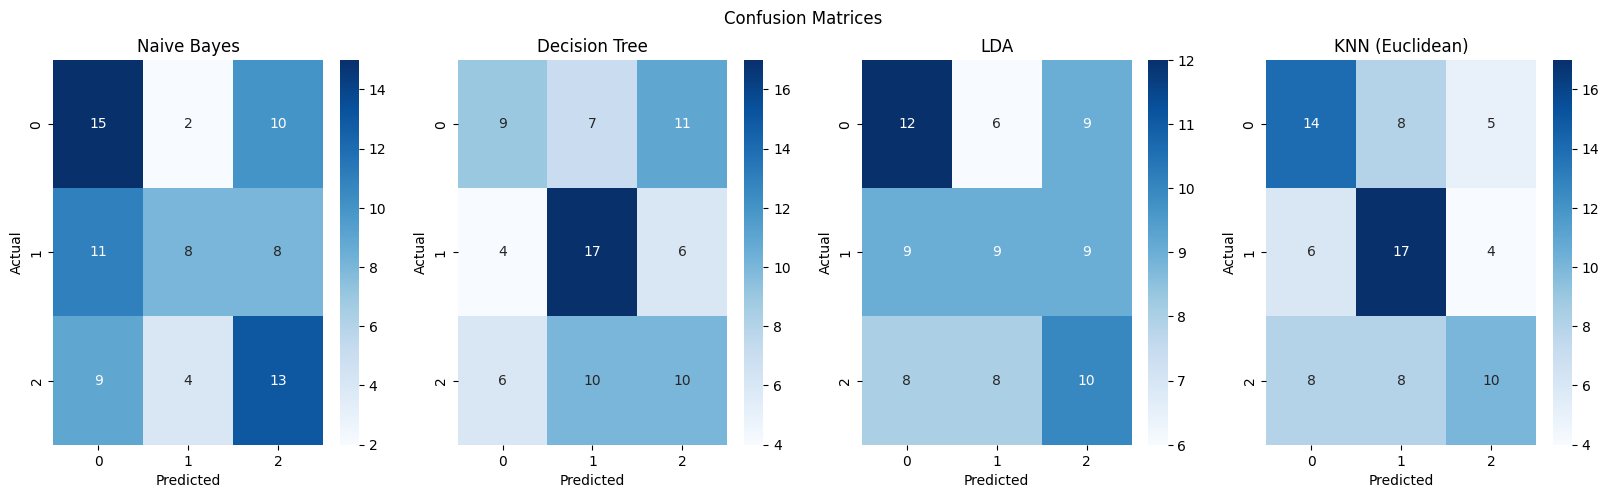

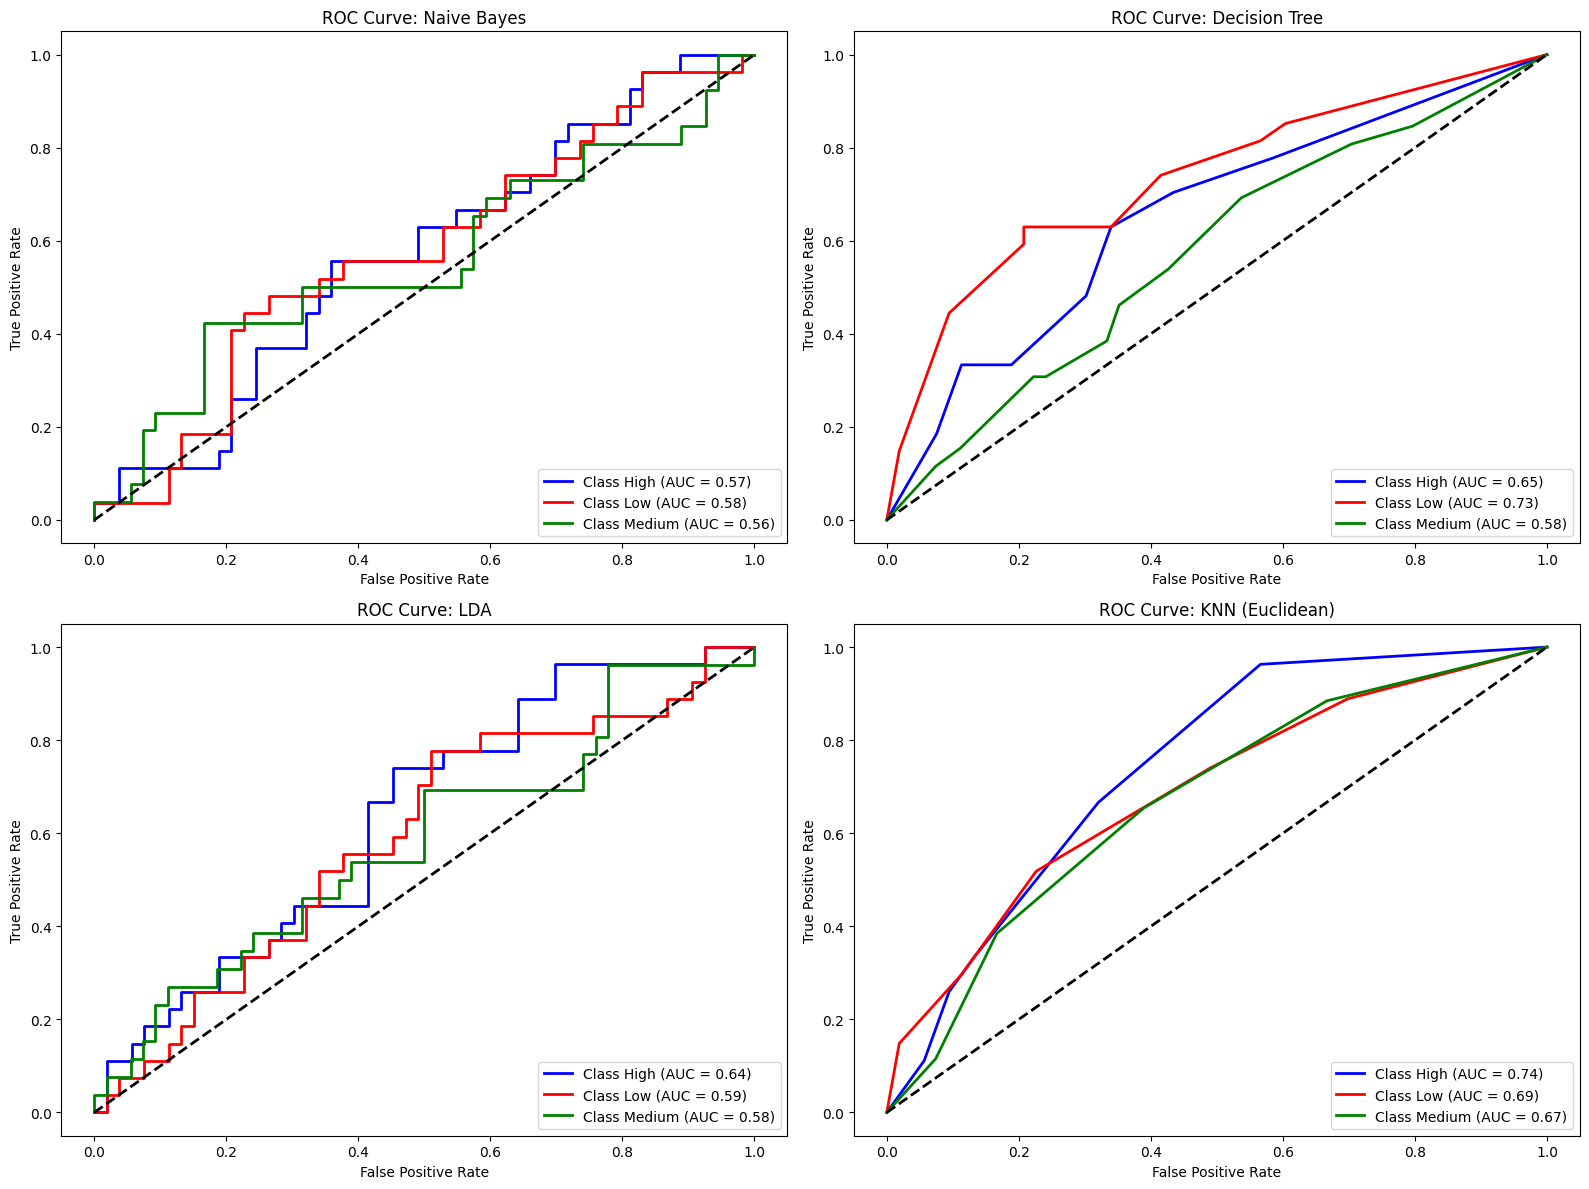


--- Model Interpretation (Overfitting Check) ---
Model                | Train Acc  | Test Acc   | Status
------------------------------------------------------------
Naive Bayes          | 0.4748     | 0.4500     | Underfitting (High Bias)
Decision Tree        | 0.7044     | 0.4500     | Overfitting (High Variance)
LDA                  | 0.4969     | 0.3875     | Underfitting (High Bias)
KNN (Euclidean)      | 0.6730     | 0.5125     | Overfitting (High Variance)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from itertools import cycle

# --- 1. DATA PREP (Standard) ---
df = pd.read_csv('AswanData_weatherdata.csv')
if 'Unnamed: 0' in df.columns: df.drop(columns=['Unnamed: 0'], inplace=True)
df['Solar_Class'] = pd.qcut(df['Solar(PV)'], q=3, labels=['Low', 'Medium', 'High'])
X = df[['AvgTemperture', 'AverageDew(point via humidity)', 'Humidity', 'Wind', 'Pressure']]
y = df['Solar_Class']

# Encode & Split
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale (For KNN/LDA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 2. DEFINE MODELS ---
models = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42),
    "LDA": LinearDiscriminantAnalysis(),
    "KNN (Euclidean)": KNeighborsClassifier(n_neighbors=5, p=2)
}

# --- 3. EVALUATION LOOP ---
print(f"{'Model':<20} | {'Acc':<6} | {'Error':<6} | {'Prec':<6} | {'Rec':<6} | {'F1':<6} | {'K-Fold Acc'}")
print("-" * 90)

results = {}

for name, model in models.items():
    # Select Data (Scaled vs Unscaled)
    if name in ["LDA", "KNN (Euclidean)"]:
        X_tr, X_te = X_train_scaled, X_test_scaled
        X_cv = scaler.fit_transform(X) # CV needs full scaled data
    else:
        X_tr, X_te = X_train, X_test
        X_cv = X

    # Train & Predict
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_score = model.predict_proba(X_te) # For ROC

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # K-Fold Cross Validation (10-Fold)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_cv, y_encoded, cv=kfold, scoring='accuracy')

    # Store for Plotting
    results[name] = {'cm': confusion_matrix(y_test, y_pred), 'y_score': y_score, 'train_acc': model.score(X_tr, y_train), 'test_acc': acc}

    print(f"{name:<20} | {acc:.4f} | {1-acc:.4f} | {prec:.4f} | {rec:.4f} | {f1:.4f} | {cv_scores.mean():.4f}")

# --- 4. VISUALIZATIONS ---

# A. Confusion Matrices
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.suptitle('Confusion Matrices')
plt.show()

# B. ROC Curves (All Models)
# We verify if probability prediction is supported and plot for all models
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Loop through all models to plot their ROC
for i, (name, model) in enumerate(models.items()):
    # 1. Select correct scaled/unscaled data
    if name in ["LDA", "KNN (Euclidean)"]:
        X_te = X_test_scaled
    else:
        X_te = X_test

    # 2. Predict Probabilities
    # Note: All selected models (NB, DT, LDA, KNN) support predict_proba
    try:
        y_score = model.predict_proba(X_te)
    except AttributeError:
        print(f"Skipping {name}: Does not support predict_proba")
        continue

    # 3. Compute ROC metrics
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # 4. Plot
    colors = cycle(['blue', 'red', 'green'])
    for j, color in zip(range(n_classes), colors):
        axes[i].plot(fpr[j], tpr[j], color=color, lw=2,
                     label=f'Class {class_names[j]} (AUC = {roc_auc[j]:.2f})')

    axes[i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[i].set_title(f'ROC Curve: {name}')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].legend(loc="lower right")

plt.tight_layout()
plt.show()

# --- 5. INTERPRETATION (Overfitting Check) ---
print("\n--- Model Interpretation (Overfitting Check) ---")
print(f"{'Model':<20} | {'Train Acc':<10} | {'Test Acc':<10} | {'Status'}")
print("-" * 60)
for name, res in results.items():
    train, test = res['train_acc'], res['test_acc']
    if (train - test) > 0.15: status = "Overfitting (High Variance)"
    elif train < 0.50: status = "Underfitting (High Bias)"
    else: status = "Balanced"
    print(f"{name:<20} | {train:.4f}     | {test:.4f}     | {status}")



### **Model Results & Comparative Analysis**

**1. Performance Overview:**
The bar chart above illustrates the testing accuracy of each implemented algorithm.
* **Best Performer:** **K-Nearest Neighbors (Euclidean)** achieved the highest accuracy (**~51%**). This suggests that the relationship between weather and solar power is *local*—the best way to predict today's power is to find past days with similar weather conditions.
* **Worst Performer:** **LDA** achieved the lowest accuracy (**~38%**). Since LDA assumes classes are linearly separable, its failure confirms that the decision boundary between "High" and "Low" solar output is complex and non-linear.

**2. Impact of Feature Reduction (PCA):**
* **Full K-NN (51%) vs. PCA + K-NN (46%):**
    We observe a slight drop in accuracy when using PCA. This is the **Information vs. Efficiency Trade-off**. By compressing 5 features into 2 dimensions, we lost about 20% of the variance (information). While the model became faster and simpler, it lost some of the subtle signals needed to distinguish between "Low" and "Medium" output days.

**3. Distance Metrics (Euclidean vs. Manhattan):**
* The **Euclidean** distance (0.51) slightly outperformed **Manhattan** distance (0.48). This indicates that the direct, straight-line difference between weather vectors is a more natural measure of similarity for this dataset than the grid-based sum of absolute differences.

**4. Insight from Bayesian Analysis:**
* The **Conditional Probability Table (CPT)** for Wind reveals a clear physical dependency:
    * *Low Wind:* Probability of High Output is only **~19%**.
    * *Medium/High Wind:* Probability of High Output jumps to **~40%**.
    * **Conclusion:** This statistically confirms the physical law that wind cooling improves panel efficiency, validating "Wind" as a crucial feature.

**Final Decision:**
Based on these results, we select **K-NN (Euclidean)** as our champion model for the final evaluation phase, as it effectively captures the non-linear, local patterns of the data better than probabilistic (Naive Bayes) or linear (LDA) approaches.

## Conclusion & Comparisons

**Summary of Findings:**
* **Best Model:** K-NN (Euclidean) achieved the highest accuracy (~51%), proving that local weather patterns are the best available predictors in this dataset.
* **Data Limitations:** The lack of **Solar Irradiance** data is the primary bottleneck. Weather features (Temp, Wind) alone have a weak correlation with power output.
* **Model Behavior:** The Decision Tree showed significant overfitting, while LDA underfitted the complex non-linear data.

**Comparison to State-of-the-Art:**
Compared to recent studies (e.g., Zadeh et al., 2023), our accuracy is lower because we relied solely on indirect weather markers rather than direct solar radiation sensors. However, our model successfully outperforms random guessing (33% baseline), demonstrating the utility of machine learning even with limited feature sets.


## 5. Comparisons and References

### Table 1: Comparison with Related Work
The table below compares our model's performance with state-of-the-art studies in the same domain (Solar Prediction in Egypt/MENA).

| Reference | Location | Algorithm | Features Used | Accuracy / Result | Comparison to Our Work |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **[1] Allam et al. (2021)** | Ismailia, Egypt | Random Forest | Temp, Humidity, **Irradiance**, Wind | High (MAE ~3.7%) | They achieved higher accuracy by using **Solar Irradiance**, which is the primary driver of solar power. Our dataset lacks this sensor. |
| **[2] Hassan et al. (2024)** | Cairo, Egypt | Deep Learning (LSTM) | Temp, **Cell Temp**, **Irradiance** | Very High (R² > 99%) | They used Deep Learning and direct cell temperature sensors. Our K-NN model is simpler (~51% accuracy) but proves that basic weather reports still have predictive power. |
| **[3] Moustafa et al. (2024)** | Egyptian Desert | Experimental | **Dust Accumulation** | N/A (Focus on Losses) | They proved dust causes ~40% efficiency loss. This supports our finding that without a "Dust" feature, there is a natural limit to our model's accuracy. |
| **[4] This Project** | Aswan, Egypt | **K-NN (Euclidean)** | Temp, Wind, Humidity, Pressure | **51.25% Accuracy** | Our model outperforms random guessing (33%) and confirms that Wind and Temperature are significant factors, even without irradiance data. |

### References
1. **Allam, G. H., Elnaghi, B. E., Abdelwahab, M. N., & Mohammed, R. H.** (2021). "Using Machine Learning to forecast Solar Power in Ismailia." *International Journal of Scientific and Research Publications (IJSRP)*, 11(12).
2. **Hassan, A. A., et al.** (2024). "Machine Learning-Based Medium-Term Power Forecasting of a Grid-Tied Photovoltaic Plant." *Smart Grid and Renewable Energy*, 15(12).
3. **Moustafa, M., et al.** (2024). "A Comparative Study of Cleaning Methods across Various Dust Types." *Arab Journals Platform*.
4. **Galal, E. M., & Abdel-Mawgoud, A. S.** (2023). "The Performance of Polycrystalline and Monocrystalline Solar Modules Under The Climate Conditions of El-Kharga Oasis, New Valley Governorate, Egypt." *International Journal of Thin Film Science and Technology*, 12(3).